In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

In [2]:
model = models.resnet18(weights=None)  # 학습용 ResNet18
model.fc = nn.Linear(model.fc.in_features, 10)  # MNIST 클래스 수: 10

In [3]:
model.load_state_dict(torch.load("resnet18_mnist.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),                # ResNet18 입력 크기 224x224
    transforms.Grayscale(num_output_channels=3),  # 1채널 → 3채널
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

conv1 -> torch.Size([64, 64, 112, 112])
layer1.0.conv1 -> torch.Size([64, 64, 56, 56])
layer1.0.conv2 -> torch.Size([64, 64, 56, 56])
layer1.1.conv1 -> torch.Size([64, 64, 56, 56])
layer1.1.conv2 -> torch.Size([64, 64, 56, 56])
layer2.0.conv1 -> torch.Size([64, 128, 28, 28])
layer2.0.conv2 -> torch.Size([64, 128, 28, 28])
layer2.0.downsample.0 -> torch.Size([64, 128, 28, 28])
layer2.1.conv1 -> torch.Size([64, 128, 28, 28])
layer2.1.conv2 -> torch.Size([64, 128, 28, 28])
layer3.0.conv1 -> torch.Size([64, 256, 14, 14])
layer3.0.conv2 -> torch.Size([64, 256, 14, 14])
layer3.0.downsample.0 -> torch.Size([64, 256, 14, 14])
layer3.1.conv1 -> torch.Size([64, 256, 14, 14])
layer3.1.conv2 -> torch.Size([64, 256, 14, 14])
layer4.0.conv1 -> torch.Size([64, 512, 7, 7])
layer4.0.conv2 -> torch.Size([64, 512, 7, 7])
layer4.0.downsample.0 -> torch.Size([64, 512, 7, 7])
layer4.1.conv1 -> torch.Size([64, 512, 7, 7])
layer4.1.conv2 -> torch.Size([64, 512, 7, 7])
conv1: torch.Size([64, 64, 112, 112])


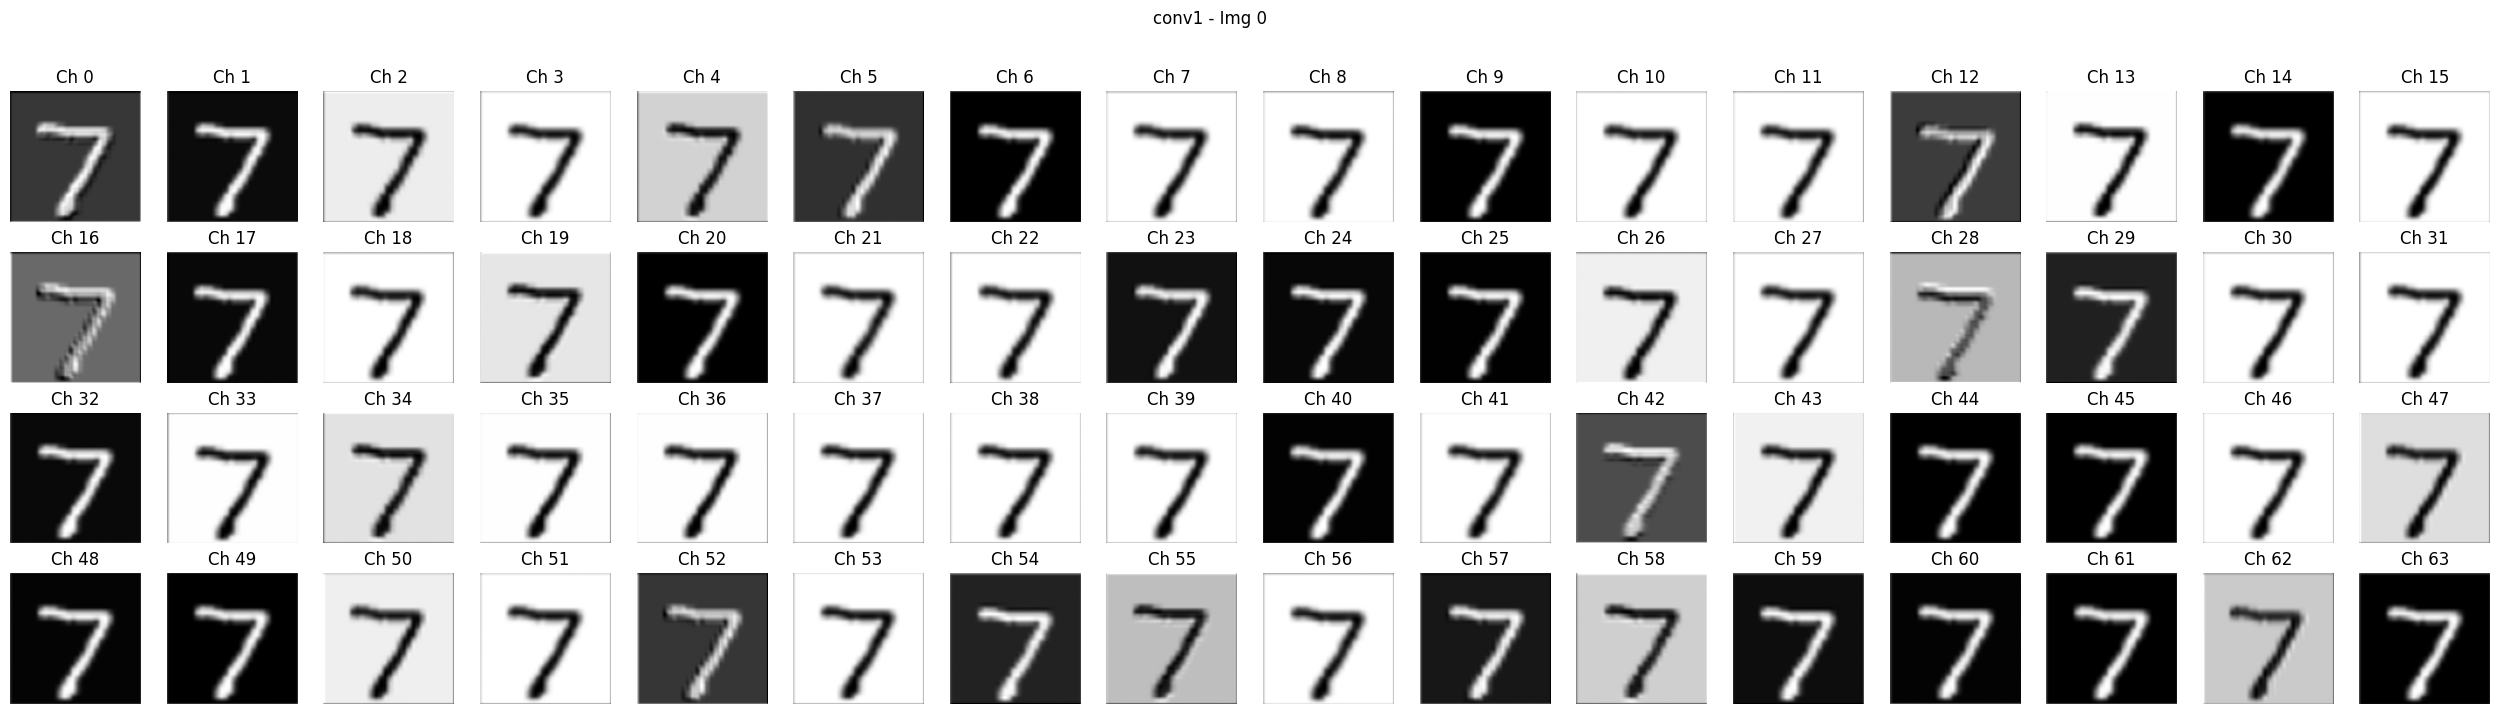

layer1.0.conv1: torch.Size([64, 64, 56, 56])


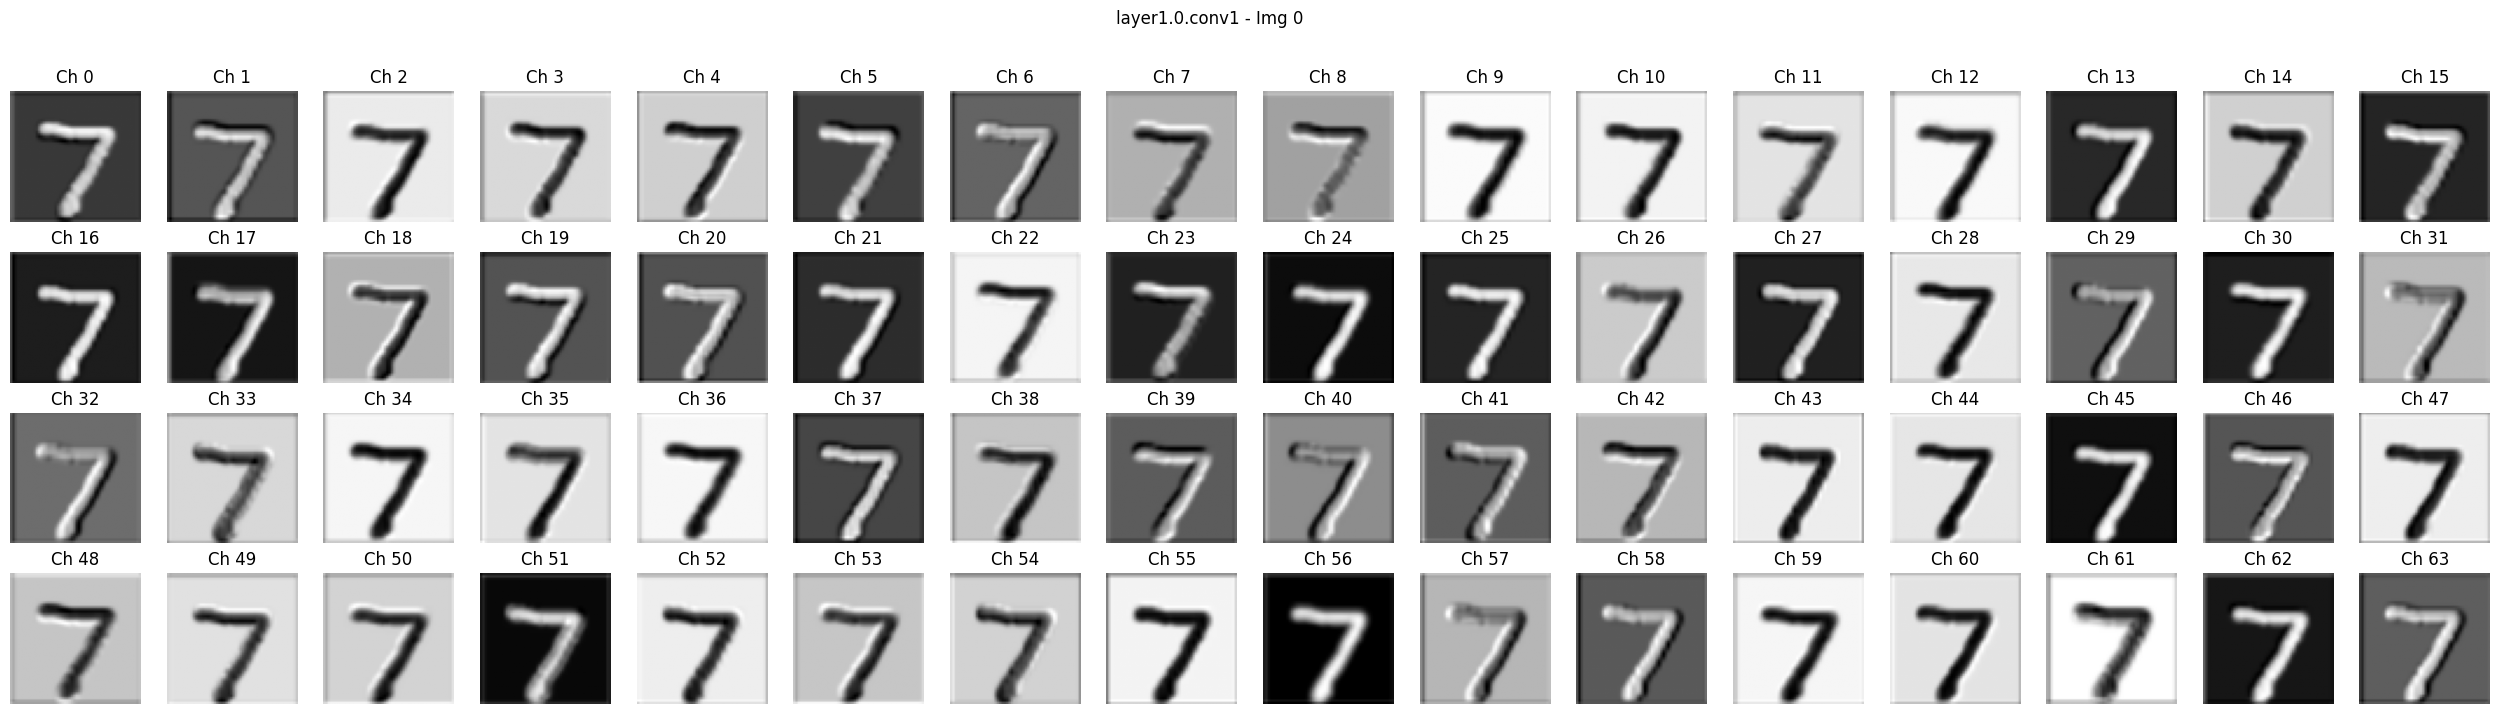

layer1.0.conv2: torch.Size([64, 64, 56, 56])


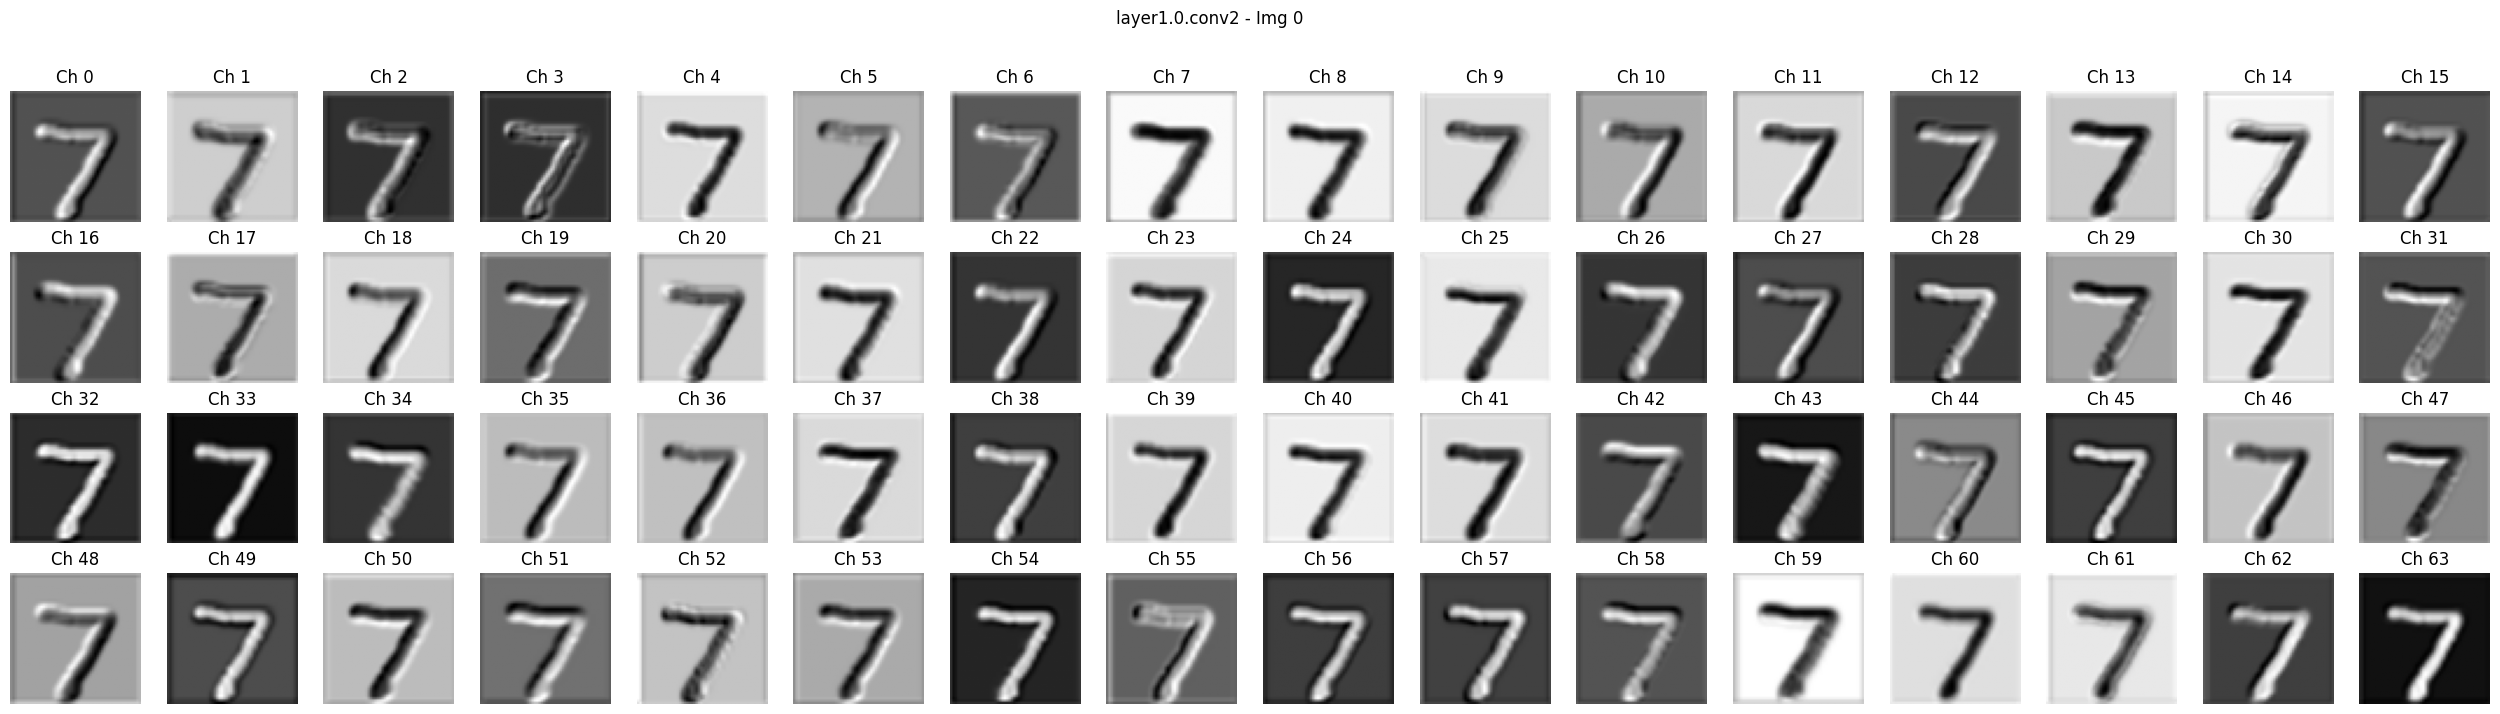

layer1.1.conv1: torch.Size([64, 64, 56, 56])


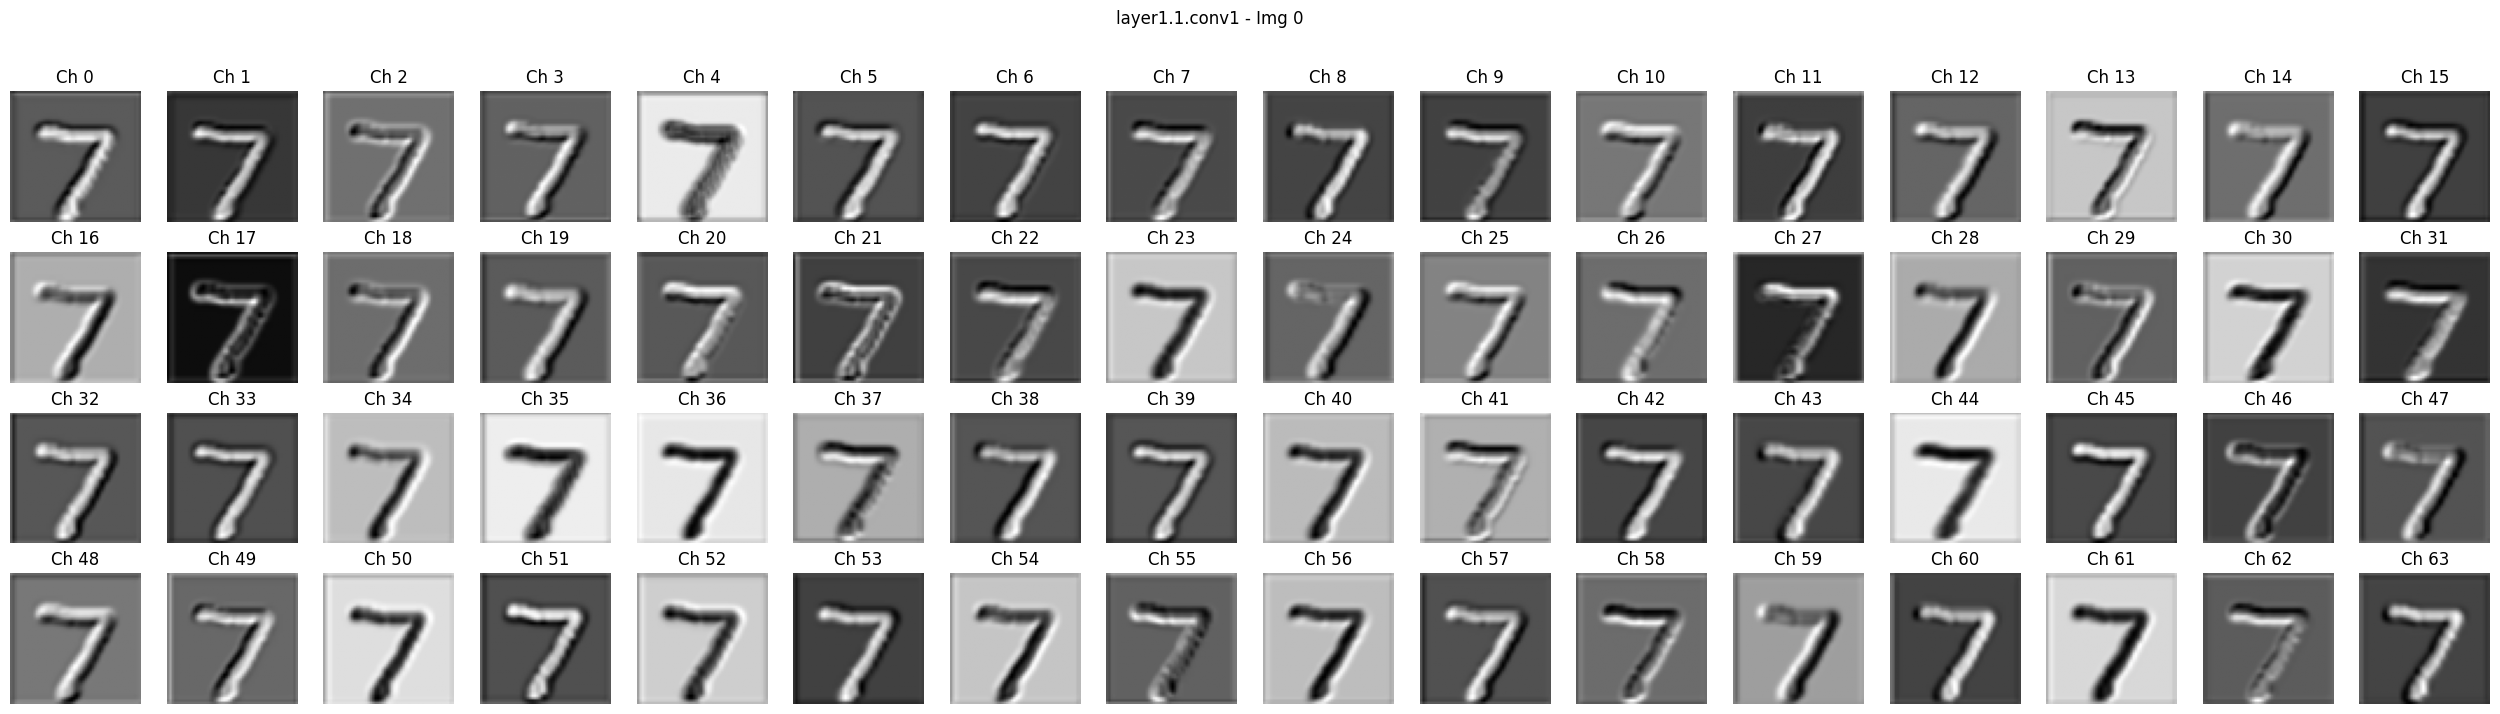

layer1.1.conv2: torch.Size([64, 64, 56, 56])


KeyboardInterrupt: 

In [ ]:
# 모델을 evaluation 모드로
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model.to(device)
model.eval()

# Conv 레이어 출력 저장용
feature_maps = {}
fc = {}
# hook 함수 정의
def save_feature(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

def save_fc(name):
    def hook(module, input, output):
        fc[name] = output.detach()
    return hook

# 모델의 모든 Conv2d 레이어에 hook 등록
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        module.register_forward_hook(save_feature(name))

model.fc.register_forward_hook(save_fc("fc"))

# 한 배치 가져오기
images, labels = next(iter(test_loader))
images = images.to(device)

# Forward pass
_ = model(images)

# 출력 확인
for layer_name, fmap in feature_maps.items():
    print(f"{layer_name} -> {fmap.shape}")  # [batch, channels, H, W]
for layer_name, fmap in fc.items():
    print(f"{layer_name} -> {fmap.shape}")  # [batch, channels, H, W]
# feature_maps: hook으로 저장된 딕셔너리
num_images = 1
for layer_name, fmap in feature_maps.items():
    batch_size, num_channels, H, W = fmap.shape
    print(f"{layer_name}: {fmap.shape}")
    
    for img_idx in range(num_images):
        # 각 채널 시각화
        n_cols = 16  # 한 줄에 8채널
        n_rows = math.ceil(num_channels / n_cols)
        plt.figure(figsize=(n_cols*2, n_rows*2))
        for ch in range(num_channels):
            plt.subplot(n_rows, n_cols, ch+1)
            plt.imshow(fmap[img_idx, ch].cpu(), cmap='gray')
            plt.axis('off')
            plt.title(f"Ch {ch}")
        plt.suptitle(f"{layer_name} - Img {img_idx}")
        plt.show()

outputs = fc["fc"][0].cpu().numpy()

plt.bar(range(len(outputs)), outputs)
plt.xlabel("Class")
plt.ylabel("Logit Value")
plt.title("FC Output (Logits)")
plt.show()


In [ ]:
import torch

# hook 저장용 dict
feature_maps = {}

def save_feature(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

# hook 등록
model.avgpool.register_forward_hook(save_feature("avgpool"))
model.fc.register_forward_hook(save_feature("fc"))

# 더미 입력 (예: RGB 이미지 크기 224x224)
x = torch.randn(1, 3, 224, 224).to(device)

# forward 실행
_ = model(x)

# 이제 feature_maps가 채워짐
print(feature_maps.keys())  
print("avgpool:", feature_maps["avgpool"].shape)
print("fc:", feature_maps["fc"].shape)